In [1]:
import numpy as np

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [3]:
from pystan import StanModel, stan

In [4]:
stan_code = """
    data {
        int<lower=1> N1;     
        vector[N1] x1; 
        vector[N1] y1;
        int<lower=1> N2;
        vector[N2] x2;
    }
    transformed data {
        int<lower=1> N;
        vector[N1+N2] x;
        vector[N1+N2] mu;
        N <- N1 + N2;
        for (n in 1:N1)
            x[n] <- x1[n];
        for (n in 1:N2)
            x[N1 + n] <- x2[n];
        for (i in 1:N)
            mu[i] <- 0;
    }
    parameters {
        real<lower=0> eta_sq;
        real<lower=0> inv_rho_sq;
        real<lower=0> sigma_sq;
        vector[N2] y2;
    }
    transformed parameters {
        real<lower=0> rho_sq;
        rho_sq <- inv(inv_rho_sq);
    }
    model {
        matrix[N,N] Sigma;
        vector[N] y;
        
        for (i in 1:(N-1)) {
            for (j in (i+1):N) {
                Sigma[i,j] <- eta_sq * exp(-rho_sq * pow(x[i] - x[j], 2));
                Sigma[j,i] <- Sigma[i,j];
            }
        }
        for (k in 1:N)
            Sigma[k,k] <- eta_sq + sigma_sq;
        
        for (n in 1:N1)
            y[n] <- y1[n];
        for (n in 1:N2)
            y[N1 + n] <- y2[n];

        eta_sq ~ cauchy(0, 5);
        inv_rho_sq ~ cauchy(0, 5);
        sigma_sq ~ cauchy(0, 5);
        
        y ~ multi_normal(mu,Sigma);
    }
"""

In [5]:
stan_model = StanModel(model_code=stan_code)

In [6]:
def targetFunction(x, jitter=0):
    if jitter > 0:
        noise = np.random.normal(scale=jitter, size=len(x))
    else:
        noise = np.zeros(shape=x.shape)
    return (x, np.sin(3*np.pi*x**2) + noise)

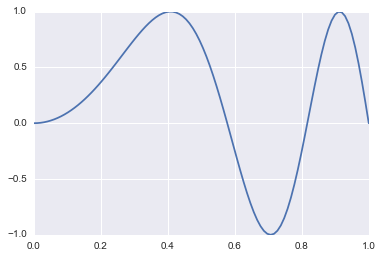

In [87]:
fig, ax = plt.subplots()
(lambda x: ax.plot(x[0], x[1]))(
    targetFunction(np.linspace(0, 1, 100, endpoint=True)))

In [7]:
def get_stan_data(
        numberOfInputs,
        numberOfNewInputs,
        jitterOnInputs=0,
        seed=0):
    np.random.seed(seed)
    return (lambda data, newInputs: {
        'N1': len(data[0]),
        'x1': data[0],
        'y1': data[1],
        'N2': len(newInputs),
        'x2': newInputs})(
            targetFunction(
                np.sort(np.random.random_sample(size=numberOfInputs)),
                jitterOnInputs),
            np.linspace(0, 1, numberOfNewInputs, endpoint=True))

In [8]:
def plot_stan_samples(stan_data, stan_samples):
    fig, ax = plt.subplots()

    mu, std = (lambda y2: (y2.mean(axis=0), y2.std(axis=0)))(
        stan_samples['y2'])
    
    ax.scatter(
        stan_data['x1'], stan_data['y1'])
    ax.plot(
        stan_data['x2'], mu)
    ax.fill_between(
        stan_data['x2'], mu-std, mu+std, alpha=0.5)

# 10 data points, no jitter

In [30]:
stan_data = get_stan_data(
    numberOfInputs=10,
    numberOfNewInputs=100,
    jitterOnInputs=0)

In [31]:
stan_nuts = stan_model.sampling(data=stan_data)

In [32]:
stan_nuts = stan_model.sampling(
    data=stan_data,
    iter=10000,
    warmup=9000,
    chains=16)

In [33]:
stan_samples = stan_nuts.extract(permuted=True)

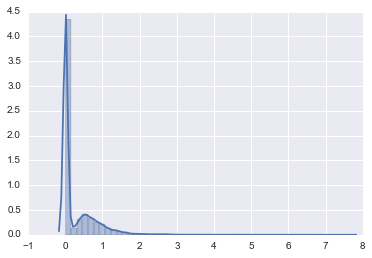

In [34]:
sns.distplot(stan_nuts.extract(permuted=True)['sigma_sq'])

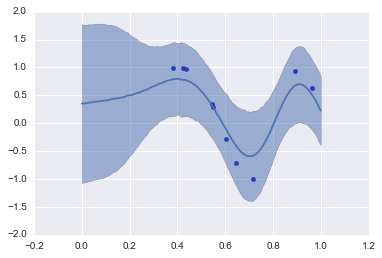

In [35]:
plot_stan_samples(stan_data, stan_samples)

# 14 data points, no jitter

In [14]:
stan_data = get_stan_data(
    numberOfInputs=14,
    numberOfNewInputs=100,
    jitterOnInputs=0)

In [16]:
stan_nuts = stan_model.sampling(data=stan_data)

In [17]:
stan_samples = stan_nuts.extract(permuted=True)

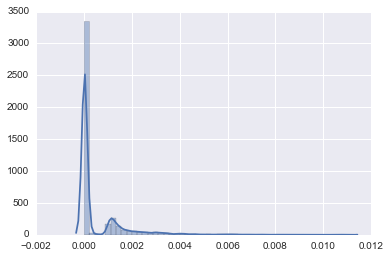

In [18]:
sns.distplot(stan_nuts.extract(permuted=True)['sigma_sq'])

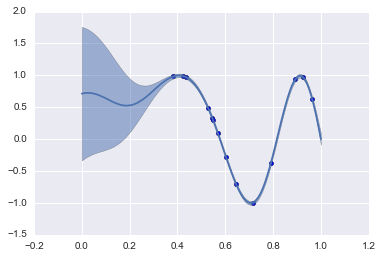

In [19]:
plot_stan_samples(stan_data, stan_samples)

# 15 data points, no jitter

In [20]:
stan_data = get_stan_data(
    numberOfInputs=15,
    numberOfNewInputs=100,
    jitterOnInputs=0)

In [21]:
stan_nuts = stan_model.sampling(data=stan_data)

In [22]:
stan_samples = stan_nuts.extract(permuted=True)

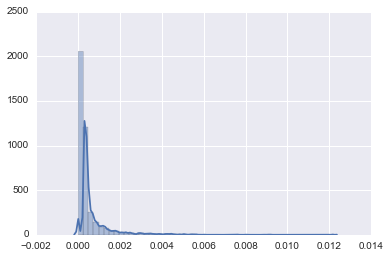

In [23]:
sns.distplot(stan_nuts.extract(permuted=True)['sigma_sq'])

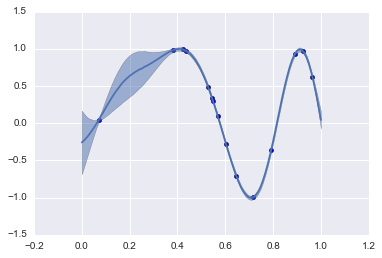

In [24]:
plot_stan_samples(stan_data, stan_samples)

# 25 data points, no jitter

In [25]:
stan_data = get_stan_data(
    numberOfInputs=25,
    numberOfNewInputs=100,
    jitterOnInputs=0)

In [26]:
stan_nuts = stan_model.sampling(data=stan_data)

In [27]:
stan_samples = stan_nuts.extract(permuted=True)

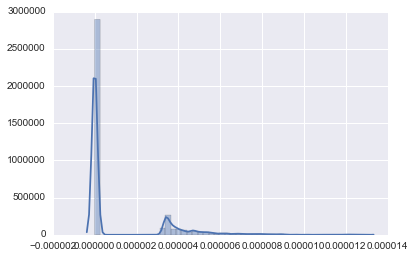

In [28]:
sns.distplot(stan_nuts.extract(permuted=True)['sigma_sq'])

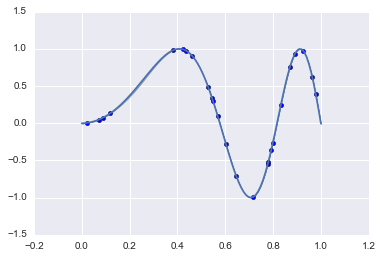

In [29]:
plot_stan_samples(stan_data, stan_samples)

# 25 data points, little jitter

In [36]:
stan_data = get_stan_data(
    numberOfInputs=25,
    numberOfNewInputs=100,
    jitterOnInputs=.1)

In [37]:
stan_nuts = stan_model.sampling(data=stan_data)

In [38]:
stan_samples = stan_nuts.extract(permuted=True)

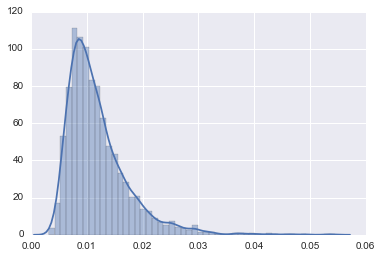

In [39]:
sns.distplot(stan_nuts.extract(permuted=True)['sigma_sq'])

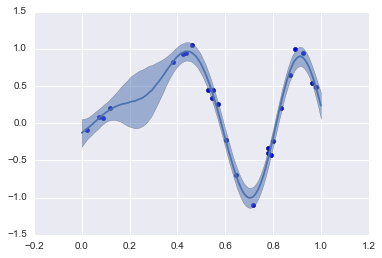

In [40]:
plot_stan_samples(stan_data, stan_samples)

# 25 data points, more jitter

In [76]:
stan_data = get_stan_data(
    numberOfInputs=25,
    numberOfNewInputs=100,
    jitterOnInputs=.4)

In [81]:
stan_nuts = stan_model.sampling(
    data=stan_data,
    iter=5000,
    warmup=2000,
    chains=16)

In [82]:
stan_samples = stan_nuts.extract(permuted=True)

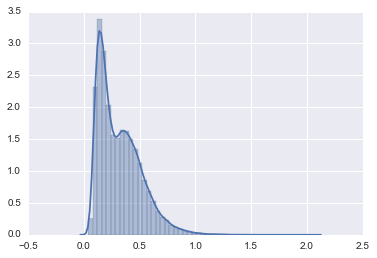

In [83]:
sns.distplot(stan_nuts.extract(permuted=True)['sigma_sq'])

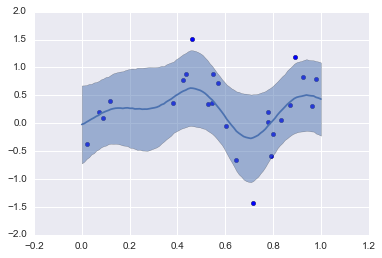

In [84]:
plot_stan_samples(stan_data, stan_samples)

# 25 data points, a lot of jitter

In [50]:
stan_data = get_stan_data(
    numberOfInputs=25,
    numberOfNewInputs=100,
    jitterOnInputs=1)

In [51]:
stan_nuts = stan_model.sampling(data=stan_data)

In [52]:
stan_nuts = stan_model.sampling(
    data=stan_data,
    iter=10000,
    warmup=9000,
    chains=16)

In [53]:
stan_samples = stan_nuts.extract(permuted=True)

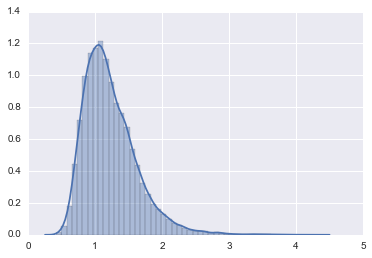

In [54]:
sns.distplot(stan_nuts.extract(permuted=True)['sigma_sq'])

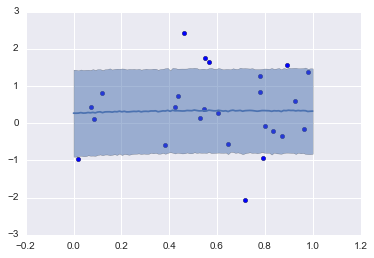

In [55]:
plot_stan_samples(stan_data, stan_samples)